# Starter Notebook

Install and import required libraries

In [ ]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3
!pip install scikit-learn
!pip install torch


In [12]:
!pip install --force-reinstall --no-cache-dir numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 79.7 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.1
    Uninstalling numpy-1.24.1:
      Successfully uninstalled numpy-1.24.1

[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [13]:
import numpy as np
print(np.__version__)

1.24.1


In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !zip -r "/content/adapted_llm.zip" "/content/adapted_llm"

In [14]:
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel, concatenate_datasets
import pickle
import numpy as np

In [ ]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

torch.cuda.empty_cache()


Fri Apr 18 05:40:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   75C    P0             41W /   70W |    1756MiB /  15360MiB |     88%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [17]:
if USE_LLM_DOMAIN_AUGMENTATION:
    from transformers import AutoTokenizer
    from datasets import Dataset

    # Load unlabeled dataset
    unlabelled_dataset = pd.read_pickle("./test_unlabelled.pkl")
    if not isinstance(unlabelled_dataset, Dataset):
        unlabelled_dataset = Dataset.from_pandas(unlabelled_dataset)

    # Load tokenizer and set padding token
    llm_tokenizer = AutoTokenizer.from_pretrained(LLM_MODEL_NAME)
    llm_tokenizer.pad_token = llm_tokenizer.eos_token

    # Tokenization function
    def tokenize_for_lm(example):
        return llm_tokenizer(
            example["text"],
            truncation=True,
            padding="max_length",
            max_length=DATA_FILTER_MAX_LENGTH
        )

    # Tokenize dataset
    tokenized_unlabelled = unlabelled_dataset.map(tokenize_for_lm, batched=True)

TypeError: _reconstruct: First argument must be a sub-type of ndarray

In [21]:
import pickle
with open("./test_unlabelled.pkl", "rb") as f:
    obj = pickle.load(f, encoding="latin1")

print(type(obj))

TypeError: _reconstruct: First argument must be a sub-type of ndarray

In [23]:
from datasets import load_from_disk

unlabelled_dataset = load_from_disk("./test_unlabelled")

FileNotFoundError: Directory ./test_unlabelled not found

In [ ]:
if USE_LLM_DOMAIN_AUGMENTATION:
  from transformers import AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling

  lm_model = AutoModelForCausalLM.from_pretrained(LLM_MODEL_NAME)

  training_args = TrainingArguments(
      output_dir=ADAPTED_LLM_PATH,
      per_device_train_batch_size=4,
      num_train_epochs=3,
      logging_steps=50,
      save_steps=500,
      save_total_limit=2,
      fp16=True,
      overwrite_output_dir=True,
  )

  trainer = Trainer(
      model=lm_model,
      args=training_args,
      train_dataset=tokenized_unlabelled,
      data_collator=DataCollatorForLanguageModeling(llm_tokenizer, mlm=False)
  )

  trainer.train()
  trainer.save_model(ADAPTED_LLM_PATH)
  llm_tokenizer.save_pretrained(ADAPTED_LLM_PATH)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
50,5.115200
100,4.954600
150,4.907000
200,4.777700
250,4.851700
300,4.690900
350,4.716300
400,4.646300
450,4.807300
500,4.748000


## Load Tokenizer and Preprocess Data

In [58]:
# Step 1: Load Tokenizer and Preprocess Data

base_model = MODEL_NAME

dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

In [62]:
from transformers import pipeline, set_seed
from datasets import Dataset
import random
import numpy as np
import time

if USE_LLM_DOMAIN_AUGMENTATION:
    print("Performing LLM-based domain augmentation...")

    # Generation Parameters
    NUM_LLM_GENERATIONS_PER_CLASS = 3000
    BATCH_SIZE = 50
    MAX_LENGTH = 128
    REPETITION_PENALTY = 1.3  # 🔁 Increase to discourage repetitive output

    set_seed(42)

    # Load the LLM pipeline
    generator = pipeline("text-generation", model=ADAPTED_LLM_PATH, device=0)

    # Diverse prompts for each AGNews class
    AGNEWS_PROMPTS = {
        0: [
            "Write a short article about global affairs:",
            "Describe a recent international political event:",
            "Report on a global crisis:",
            "Summarize a UN meeting:",
            "Headline news from Europe:",
            "Describe a geopolitical conflict:",
            "World headline story:",
            "Write a short report about international tensions:",
            "What is happening globally today?",
            "Write a short update on international relations:",
            "Write a brief article about world diplomacy:",
            "Cover a story from Asia or Africa:",
            "Cover a story from Middle East or Western Asia:",
            "What is the latest in foreign policy?",
            "Write a short international incident report:",
            "Describe a breaking world news story:"
        ],
        1: [
            "Write a short sports update:",
            "Describe a recent football match:",
            "Write a short NBA game report:",
            "Report on a tennis tournament:",
            "Write about a famous athlete's performance:",
            "Describe a recent soccer win:",
            "Write a short piece about a sports upset:",
            "What happened in sports this week?",
            "Summarize a recent game:",
            "Short sports commentary:",
            "Who won the match today?",
            "Write a sports new based in Africa",
            "Write a sports new based in Southeast Asia",
            "Write a sports new based in the US",
            "Write a sports new based in South America",
            "Describe a record-breaking sports moment:",
            "Write a recap of a boxing match:",
            "Short news on Olympic sports:",
            "Write a short report on a sports scandal:"
        ],
        2: [
            "Write a short business article:",
            "Describe a stock market change:",
            "Report on a major company merger:",
            "Summarize an economic trend:",
            "What is happening in finance today?",
            "Write a short article about corporate news:",
            "Describe a recent economic development:",
            "Write about business earnings reports:",
            "Cover a tech startup acquisition:",
            "Write about inflation or interest rate news:",
            "Describe a company going public:",
            "Summarize a business scandal:",
            "Write a headline about Wall Street:",
            "Write about a global economic issue:",
            "Write about a business article on the sports industry:",
            "Write about a business article on the sports industry:",
            "Write about a business article on the sports industry:",
            "Short report on trade and markets:"
        ],
        3: [
            "Write a short tech article:",
            "Describe a recent space discovery:",
            "What’s new in artificial intelligence?",
            "Write a short article about scientific progress:",
            "Summarize a new research paper:",
            "Write about a medical breakthrough:",
            "Describe a new tech gadget:",
            "Write about a NASA update:",
            "Report on an academic conference:",
            "Cover a story about climate science:",
            "Write about electric vehicles innovation:",
            "Describe a recent invention:",
            "Summarize a finding in biology:",
            "What’s trending in technology?",
            "Write a tech or science article with business related words",
            "Write a tech or science article with business related words",
            "Write a tech article from someone outside of the US",
            "Write about computer science progress:"
        ]
    }

    # Word-length based sampling for variable output length
    def sample_max_length():
        # Draw from a normal distribution centered around 45, std dev 12
        sampled = int(np.random.normal(loc=45, scale=12))
        # Clamp values to ensure they’re between 1 and 128
        return max(1, min(MAX_LENGTH, sampled))

    synthetic_samples = []

    for label, prompt_list in AGNEWS_PROMPTS.items():
        print(f"\n Generating {NUM_LLM_GENERATIONS_PER_CLASS} samples for label {label}...")

        for i in range(0, NUM_LLM_GENERATIONS_PER_CLASS, BATCH_SIZE):
            current_batch_size = min(BATCH_SIZE, NUM_LLM_GENERATIONS_PER_CLASS - i)
            prompts = random.choices(prompt_list, k=current_batch_size)
            max_len = sample_max_length()

            start = time.time()
            outputs = generator(
                prompts,
                max_length=max_len,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                truncation=True,
                repetition_penalty=REPETITION_PENALTY
            )

            # Remove the prompt from each output
            for prompt, generated_list in zip(prompts, outputs):
                for out in generated_list:  # iterate over outputs per prompt
                    text = out["generated_text"]
                    cleaned = text.replace(prompt, "").strip()
                    synthetic_samples.append({"text": cleaned, "label": label})

            print(f"   ✅ Batch {i + current_batch_size}/{NUM_LLM_GENERATIONS_PER_CLASS} in {time.time() - start:.2f}s")

    # Save as Hugging Face dataset
    aug_llm_dataset = Dataset.from_list(synthetic_samples)
    aug_llm_dataset = aug_llm_dataset.cast_column("label", dataset.features["label"])
    aug_llm_dataset.save_to_disk("/content/drive/MyDrive/Deep Learning/P2/unlabeled_data/aug_llm_dataset_ultra")

    print("✅ Saved to disk at: aug_llm_dataset_cleaned")

🔁 Performing LLM-based domain augmentation...


Device set to use cuda:0



📰 Generating 3000 samples for label 0...
   ✅ Batch 50/3000 in 28.43s
   ✅ Batch 100/3000 in 20.11s
   ✅ Batch 150/3000 in 24.49s
   ✅ Batch 200/3000 in 32.10s
   ✅ Batch 250/3000 in 18.68s
   ✅ Batch 300/3000 in 19.52s
   ✅ Batch 350/3000 in 48.54s
   ✅ Batch 400/3000 in 28.13s
   ✅ Batch 450/3000 in 17.80s


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


   ✅ Batch 500/3000 in 25.00s
   ✅ Batch 550/3000 in 17.28s
   ✅ Batch 600/3000 in 17.10s
   ✅ Batch 650/3000 in 21.93s
   ✅ Batch 700/3000 in 7.66s
   ✅ Batch 750/3000 in 9.21s
   ✅ Batch 800/3000 in 19.60s
   ✅ Batch 850/3000 in 13.40s
   ✅ Batch 900/3000 in 21.67s
   ✅ Batch 950/3000 in 14.95s
   ✅ Batch 1000/3000 in 11.33s
   ✅ Batch 1050/3000 in 30.60s
   ✅ Batch 1100/3000 in 18.77s
   ✅ Batch 1150/3000 in 21.92s
   ✅ Batch 1200/3000 in 10.93s
   ✅ Batch 1250/3000 in 16.63s
   ✅ Batch 1300/3000 in 21.12s
   ✅ Batch 1350/3000 in 13.06s
   ✅ Batch 1400/3000 in 22.53s
   ✅ Batch 1450/3000 in 16.30s
   ✅ Batch 1500/3000 in 18.39s
   ✅ Batch 1550/3000 in 15.94s
   ✅ Batch 1600/3000 in 32.93s
   ✅ Batch 1650/3000 in 19.48s
   ✅ Batch 1700/3000 in 13.52s
   ✅ Batch 1750/3000 in 26.60s
   ✅ Batch 1800/3000 in 12.50s
   ✅ Batch 1850/3000 in 22.02s
   ✅ Batch 1900/3000 in 7.40s
   ✅ Batch 1950/3000 in 11.69s
   ✅ Batch 2000/3000 in 22.20s
   ✅ Batch 2050/3000 in 25.02s
   ✅ Batch 2100/3000 

Casting the dataset:   0%|          | 0/12000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/12000 [00:00<?, ? examples/s]

✅ Saved to disk at: aug_llm_dataset_cleaned


In [63]:
    # Save as Hugging Face dataset
    # aug_llm_dataset = Dataset.from_list(synthetic_samples)
    # aug_llm_dataset = aug_llm_dataset.cast_column("label", dataset.features["label"])
    aug_llm_dataset.save_to_disk("/content/drive/MyDrive/Deep Learning/P2/unlabeled_data/aug_llm_dataset_ultra")

    print("✅ Saved to disk at: aug_llm_dataset_ultra")

Saving the dataset (0/1 shards):   0%|          | 0/12000 [00:00<?, ? examples/s]

✅ Saved to disk at: aug_llm_dataset_ultra


In [ ]:
from transformers import pipeline, set_seed
from datasets import Dataset
import random
import time

if USE_LLM_DOMAIN_AUGMENTATION:
    print("🔁 Performing LLM-based domain augmentation...")

    # Load the LLM on GPU (device=0)
    generator = pipeline("text-generation", model="adapted_llm", device=0)
    set_seed(42)

    AGNEWS_PROMPTS = {
        0: "Write a short world news article:",
        1: "Write a short sports news article:",
        2: "Write a short business news article:",
        3: "Write a short science or tech news article:"
    }

    BATCH_SIZE = 50
    synthetic_samples = []

    for label, prompt in AGNEWS_PROMPTS.items():
        print(f"→ Generating {NUM_LLM_GENERATIONS_PER_CLASS} samples for label {label}...")

        for i in range(0, NUM_LLM_GENERATIONS_PER_CLASS, BATCH_SIZE):
            current_batch_size = min(BATCH_SIZE, NUM_LLM_GENERATIONS_PER_CLASS - i)
            start = time.time()
            outputs = generator(
                prompt,
                max_length=128,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                num_return_sequences=current_batch_size,
                truncation=True
            )
            for out in outputs:
                synthetic_samples.append({"text": out["generated_text"], "label": label})

            print(f"   ✅ Batch {i + current_batch_size}/{NUM_LLM_GENERATIONS_PER_CLASS} in {time.time() - start:.2f}s")

    aug_llm_dataset = Dataset.from_list(synthetic_samples)
    aug_llm_dataset = aug_llm_dataset.cast_column("label", dataset.features["label"])
    aug_llm_dataset.save_to_disk("/content/drive/MyDrive/Deep Learning/P2/unlabeled_data/aug_llm_dataset")

🔁 Performing LLM-based domain augmentation...


Device set to use cuda:0


→ Generating 2000 samples for label 0...
   ✅ Batch 50/2000 in 2.15s
   ✅ Batch 100/2000 in 2.11s
   ✅ Batch 150/2000 in 2.12s
   ✅ Batch 200/2000 in 2.13s
   ✅ Batch 250/2000 in 2.17s
   ✅ Batch 300/2000 in 2.43s
   ✅ Batch 350/2000 in 2.35s
   ✅ Batch 400/2000 in 2.15s
   ✅ Batch 450/2000 in 2.13s
   ✅ Batch 500/2000 in 2.13s
   ✅ Batch 550/2000 in 2.28s
   ✅ Batch 600/2000 in 2.42s
   ✅ Batch 650/2000 in 2.16s
   ✅ Batch 700/2000 in 2.16s
   ✅ Batch 750/2000 in 2.15s
   ✅ Batch 800/2000 in 2.14s
   ✅ Batch 850/2000 in 2.35s
   ✅ Batch 900/2000 in 2.28s
   ✅ Batch 950/2000 in 2.15s
   ✅ Batch 1000/2000 in 2.16s
   ✅ Batch 1050/2000 in 2.14s
   ✅ Batch 1100/2000 in 2.14s
   ✅ Batch 1150/2000 in 2.37s
   ✅ Batch 1200/2000 in 2.18s
   ✅ Batch 1250/2000 in 2.10s
   ✅ Batch 1300/2000 in 2.12s
   ✅ Batch 1350/2000 in 2.12s
   ✅ Batch 1400/2000 in 2.12s
   ✅ Batch 1450/2000 in 2.33s
   ✅ Batch 1500/2000 in 2.14s
   ✅ Batch 1550/2000 in 2.10s
   ✅ Batch 1600/2000 in 2.10s
   ✅ Batch 1650/200

Casting the dataset:   0%|          | 0/8000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/8000 [00:00<?, ? examples/s]

In [ ]:
from datasets import load_from_disk, Dataset
import os

# Load your generated dataset
aug_llm_dataset = load_from_disk("/content/drive/MyDrive/Deep Learning/P2/unlabeled_data/aug_llm_dataset")

# Prompts used during generation (must match what was prepended)
AGNEWS_PROMPTS = {
    0: "Write a short world news article:",
    1: "Write a short sports news article:",
    2: "Write a short business news article:",
    3: "Write a short science or tech news article:"
}

# Function to remove the prompt from each text entry
def remove_prompt(example):
    prompt = AGNEWS_PROMPTS[example["label"]]
    if example["text"].startswith(prompt):
        example["text"] = example["text"].replace(prompt, "", 1).strip()
    return example

# Apply the cleanup
cleaned_dataset = aug_llm_dataset.map(remove_prompt)

# Save to a new location (optional: overwrite original if desired)
clean_path = "/content/drive/MyDrive/Deep Learning/P2/unlabeled_data/aug_llm_dataset_cleaned"
if not os.path.exists(clean_path):
    cleaned_dataset.save_to_disk(clean_path)

print("✅ Cleaned dataset saved to:", clean_path)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/8000 [00:00<?, ? examples/s]

✅ Cleaned dataset saved to: /content/drive/MyDrive/Deep Learning/P2/unlabeled_data/aug_llm_dataset_cleaned


In [ ]:
# Explore and check the generated augmented samples. We will print 5 of each class.

import random

# AGNews label names (optional, for nicer output)
label_names = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech"
}

# Make sure the dataset is shuffled first (if not already)
aug_llm_dataset = aug_llm_dataset.shuffle(seed=42)

# For each label (0 to 3), print 5 samples
for label in range(4):
    print(f"\n📰 Label {label}: {label_names[label]}")
    samples = [ex["text"] for ex in aug_llm_dataset if ex["label"] == label]
    random_samples = random.sample(samples, k=min(5, len(samples)))  # just in case <5 exist
    for i, sample in enumerate(random_samples, 1):
        print(f"\nSample {i}:\n{sample.strip()}")

AttributeError: 'str' object has no attribute 'shuffle'

In [38]:
if APPLY_LLM_DOMAIN_AUG:

  from datasets import load_from_disk, concatenate_datasets

  # Load AGNews
  from datasets import load_dataset
  agnews_dataset = load_dataset("ag_news", split="train")

  # Load your saved generated data
  aug_llm_dataset = load_from_disk("/content/drive/MyDrive/Deep Learning/P2/aug_llm_dataset_cleaned")

  # Concatenate
  combined_dataset = concatenate_datasets([agnews_dataset, aug_llm_dataset])
  dataset = combined_dataset.shuffle(seed=42)

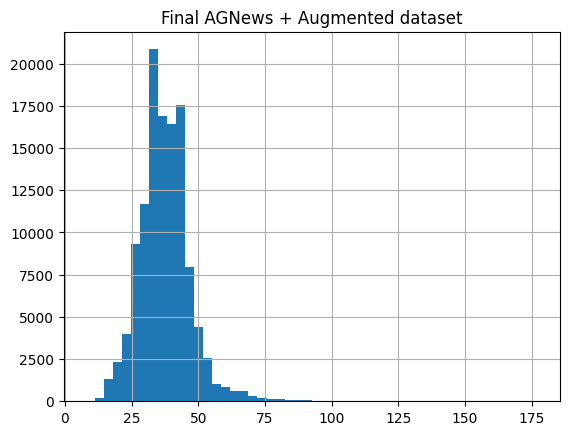

In [52]:
if USE_AUGMENTED_SAMPLES:
  # Load augmented data from pickle
  aug_df = pd.read_pickle(AUGMENTED_DATASET_PATH)
  # Convert to DataFrame if it's a Hugging Face Dataset
  if not isinstance(aug_df, pd.DataFrame):
    aug_df = aug_df.to_pandas()
  # If necessary, rename columns to match AGNews
  aug_df.rename(columns={AUGMENTED_DATASET_TEXT_COLUMN: "text", AUGMENTED_DATASET_LABEL_COLUMN: "label"}, inplace=True)  # <-- remove if already named correctly

  # Convert to HuggingFace dataset
  aug_dataset = Dataset.from_pandas(aug_df)
  # Match label format with AGNews (ClassLabel)
  aug_dataset = aug_dataset.cast_column("label", dataset.features["label"])

  # Explore augmented dataset
  import matplotlib.pyplot as plt
  lengths = [len(ex["text"].split()) for ex in dataset]
  plt.hist(lengths, bins=50)
  plt.title("Augmented samples dataset word length")
  plt.grid(True)
  plt.show()

  # Concatenate and shuffle
  dataset = concatenate_datasets([dataset, aug_dataset])
  dataset = dataset.shuffle(seed=42)  # ensures mixed order


#Final dataset
import matplotlib.pyplot as plt
lengths = [len(ex["text"].split()) for ex in dataset]
plt.hist(lengths, bins=50)
plt.title("Final AGNews + Augmented dataset")
plt.grid(True)
plt.show()


In [40]:
def filter_dataset(dataset, min_len=DATA_FILTER_MIN_LENGTH, max_len=DATA_FILTER_MAX_LENGTH):
    def is_valid(example):
        length = len(example["text"].split())
        return min_len <= length <= max_len
    return dataset.filter(is_valid)


# Optional: if we are using data filtering
if USE_DATA_FILTERING:
    print("Filtering dataset based on text length...")
    dataset = filter_dataset(dataset, max_len=DATA_FILTER_MAX_LENGTH)


def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")


# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")


# Load Pre-trained Model

model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels, id2label=id2label)

if TRANSFER_LEARNING_KD:
    teacher_model = RobertaForSequenceClassification.from_pretrained(TEACHER_MODEL_PATH)
    teacher_model.eval()

model


Filtering dataset based on text length...
number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## Anything from here on can be modified

In [41]:
#-------------------------------------------------------------------------------------------
# We will be modifying from here


# Split the original training set
split_datasets = tokenized_dataset.train_test_split(test_size=VALIDATION_SIZE, seed=SEED)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

## Setup LoRA Config
Setup PEFT config and get peft model for finetuning

In [42]:
#---------------------------------------------------------------------------------------------

# Step 2: Setup LoRA Config

# PEFT Config
if USE_LORA:
    # PEFT Config
    peft_config = LoraConfig(
        r=LORA_RANK,
        lora_alpha=LORA_ALPHA,
        lora_dropout=LORA_DROPOUT,
        bias=LORA_BIAS,
        target_modules=LORA_TARGET_MODULES,
        task_type="SEQ_CLS",
    )


    peft_model = get_peft_model(model, peft_config)
    if LOAD_FROM_PRETRAINED:
        peft_model = PeftModel.from_pretrained(model, STUDENT_MODEL_PATH)

    peft_model

    print('PEFT Model')
    peft_model.print_trainable_parameters()

else:
    print("Training full model (no LoRA)")


PEFT Model
trainable params: 916,996 || all params: 125,463,560 || trainable%: 0.7309


## Training Setup

In [46]:
# Step 3: Training setup

# To track evaluation accuracy during training
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy
    }


# Setup training args

print("TrainingArguments comes from:", TrainingArguments.__module__)

# Setup Training args
output_dir = "results"
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE*4,
    learning_rate=LEARNING_RATE,
    max_steps=MAX_STEPS,
    eval_strategy=EVAL_STRATEGY,         # Evaluate every epoch
    save_strategy="epoch",                     # Save checkpoint every epoch
    load_best_model_at_end=True,               # Load best checkpoint automatically
    metric_for_best_model="accuracy",          # Use accuracy to determine best model
    greater_is_better=True,                    # Higher accuracy is better
    save_total_limit=2,                        # Keep only last 2 checkpoints
    logging_dir="./logs",                      # For log storage
    logging_steps=LOGGING_STEPS,
    report_to=None,                            # Disable external logging like WandB
    optim=OPTIMIZER,                           # e.g. "adamw_torch", "rmsprop", etc.
    gradient_checkpointing=GRADIENT_CHECKPOINTING,
    gradient_checkpointing_kwargs={"use_reentrant": True},
    dataloader_num_workers=NUM_WORKERS,
    gradient_accumulation_steps= GRADIENT_ACCUM_STEPS,
    fp16 = True,
    warmup_ratio = WARMUP_RATIO,
    weight_decay= WEIGHT_DECAY
)

def get_trainer(model):
      return Trainer(
          model=model,
          args=training_args,
          compute_metrics=compute_metrics,
          train_dataset=train_dataset,
          eval_dataset=eval_dataset,
          data_collator=data_collator
      )


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


TrainingArguments comes from: transformers.training_args


## Evaluate Finetuned Model


In [47]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

In [ ]:
#------------------------------------------------------------------
#KD Trainer:
if TRANSFER_LEARNING_KD:
    import torch
    from transformers import Trainer, TrainingArguments
    import torch.nn.functional as F
    from sklearn.metrics import accuracy_score


    def compute_metrics(pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(axis=-1)
        acc = accuracy_score(labels, preds)
        return {"accuracy": acc}

    class DistillationTrainer(Trainer):
        def __init__(self, teacher_model, temperature, alpha, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.teacher = teacher_model.to(self.args.device)
            self.teacher.eval()
            self.temperature = temperature
            self.alpha = alpha

        def compute_loss(self, model, inputs, return_outputs=False, **kwargs):  # ✅ fix here
            labels = inputs.pop("labels")
            outputs_student = model(**inputs)
            logits_student = outputs_student.logits

            with torch.no_grad():
                outputs_teacher = self.teacher(**inputs)
                logits_teacher = outputs_teacher.logits

            import torch.nn.functional as F
            loss_soft = F.kl_div(
                F.log_softmax(logits_student / self.temperature, dim=-1),
                F.softmax(logits_teacher / self.temperature, dim=-1),
                reduction="batchmean"
            ) * (self.temperature ** 2)

            loss_hard = F.cross_entropy(logits_student, labels)
            loss = self.alpha * loss_hard + (1 - self.alpha) * loss_soft

            return (loss, outputs_student) if return_outputs else loss

### Custom Training for transfer learning from teacher to student

In [ ]:
#------------------------------------------------------------------
#KD Trainer:
if TRANSFER_LEARNING_KD:
    # --------------------------
    # TRAINING SETUP
    # --------------------------

    from transformers import DataCollatorWithPadding
    data_collator = DataCollatorWithPadding(tokenizer)

    training_args = TrainingArguments(
        output_dir=OUTPUT_DIR,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        max_steps= MAX_STEPS_KD,  # 🚨 This overrides num_train_epochs
        eval_strategy="steps",
        eval_steps=EVAL_STEPS,
        save_strategy="steps",
        save_steps=SAVE_STEPS,
        logging_steps=50,
        learning_rate=LEARNING_RATE,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        report_to=None,
        fp16=True
    )

    trainer = DistillationTrainer(
        model=model,
        teacher_model=teacher_model,
        args=training_args,
        train_dataset=tokenized_dataset,
        eval_dataset=eval_dataset,
        data_collator=data_collator,
        tokenizer=tokenizer,
        temperature=TEMPERATURE,
        alpha=ALPHA,
        compute_metrics=compute_metrics
    )

    if RESUMING_KD_FROM_CHECKPOINT:
      trainer.train(resume_from_checkpoint=CHECKPOINT_PATH_RESUME_KD)
    else:
      trainer.train()

### Standard Training for both Student and Teacher

In [48]:
#---------------------------------------------------------------------------------------------

if not TRANSFER_LEARNING_KD:

    # Step 4: Start training

    if TRAIN_TEACHER_KD:
      trainer = get_trainer(model)
    else:
      trainer = get_trainer(peft_model)  # Make sure get_trainer(...) uses correct TrainingArguments

    import time

    # Train and evaluate using Hugging Face
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch + 1}/{EPOCHS}")
        start_time = time.time()

        trainer.train(resume_from_checkpoint=None)  # or pass checkpoint path if needed
        trainer.save_model(MODEL_NAME + "_model")
        trainer.save_state()  # optional: saves optimizer/scheduler/training state

        epoch_time = time.time() - start_time
        print(f"Epoch time: {epoch_time:.2f} seconds")

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.



Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.308800,0.311848,0.895234


Epoch time: 826.51 seconds

Epoch 2/10


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.273700,0.289386,0.901016


Epoch time: 830.10 seconds

Epoch 3/10


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.258700,0.278419,0.905156


Epoch time: 826.40 seconds

Epoch 4/10


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.252700,0.268254,0.908438


Epoch time: 826.11 seconds

Epoch 5/10


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

### Performing Inference on Custom Input
Uncomment following functions for running inference on custom inputs

In [ ]:
# def classify(model, tokenizer, text):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
#     output = model(**inputs)

#     prediction = output.logits.argmax(dim=-1).item()

#     print(f'\n Class: {prediction}, Label: {id2label[prediction]}, Text: {text}')
#     return id2label[prediction]

In [ ]:
# classify( peft_model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
# classify( peft_model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")

### Run Inference on eval_dataset

In [ ]:
# Check evaluation accuracy
# _, _ = evaluate_model(peft_model, eval_dataset, True, 8, data_collator)

### Run Inference on unlabelled dataset

In [ ]:
#Load your unlabelled data
def preprocess_inference(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        padding="max_length",  # ensure uniform input size
        max_length=128         # match training size
    )


unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess_inference, batched=True, remove_columns=["text"])
unlabelled_dataset

In [ ]:
# Run inference and save predictions
preds = evaluate_model(peft_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})
df_output.to_csv(os.path.join(output_dir,"inference_output.csv"), index=False)
print("Inference complete. Predictions saved to inference_output.csv")